/Users/alexamirejibi/miniconda3/envs/clusterizer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Taking random sample of 2 files from 2 total files
Successfully loaded and concatenated data. Shape: (49, 527)
Entities (columns): ['2025-02-23_cluster_0', '2025-02-23_cluster_1', '2025-02-23_cluster_2', '2025-02-23_cluster_3', '2025-02-23_cluster_4']... (Total: 527)

Processing method: cooccurrence...
Generated 'cooccurrence' matrix with shape: (49, 49)


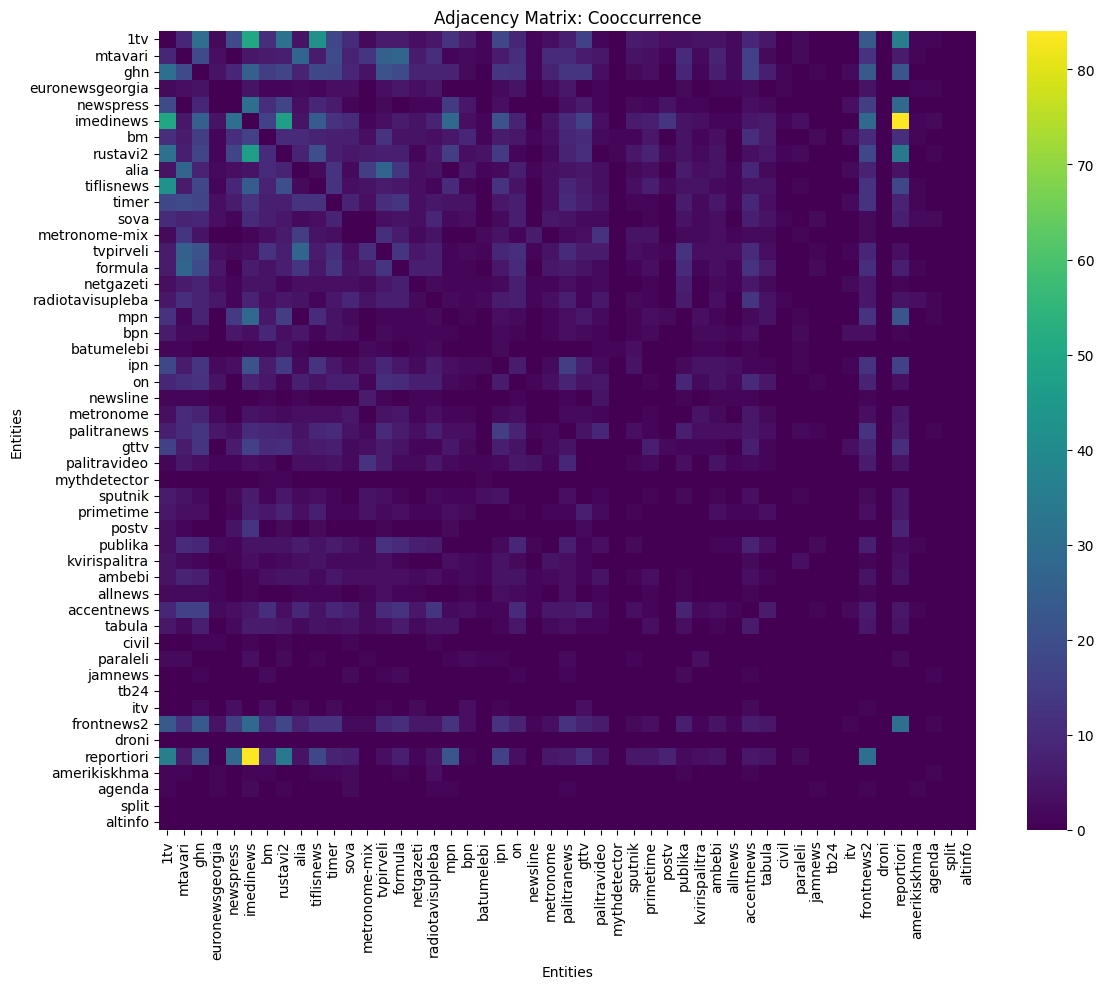

Successfully processed and visualized cooccurrence.

Processing method: jaccard...
Generated 'jaccard' matrix with shape: (49, 49)


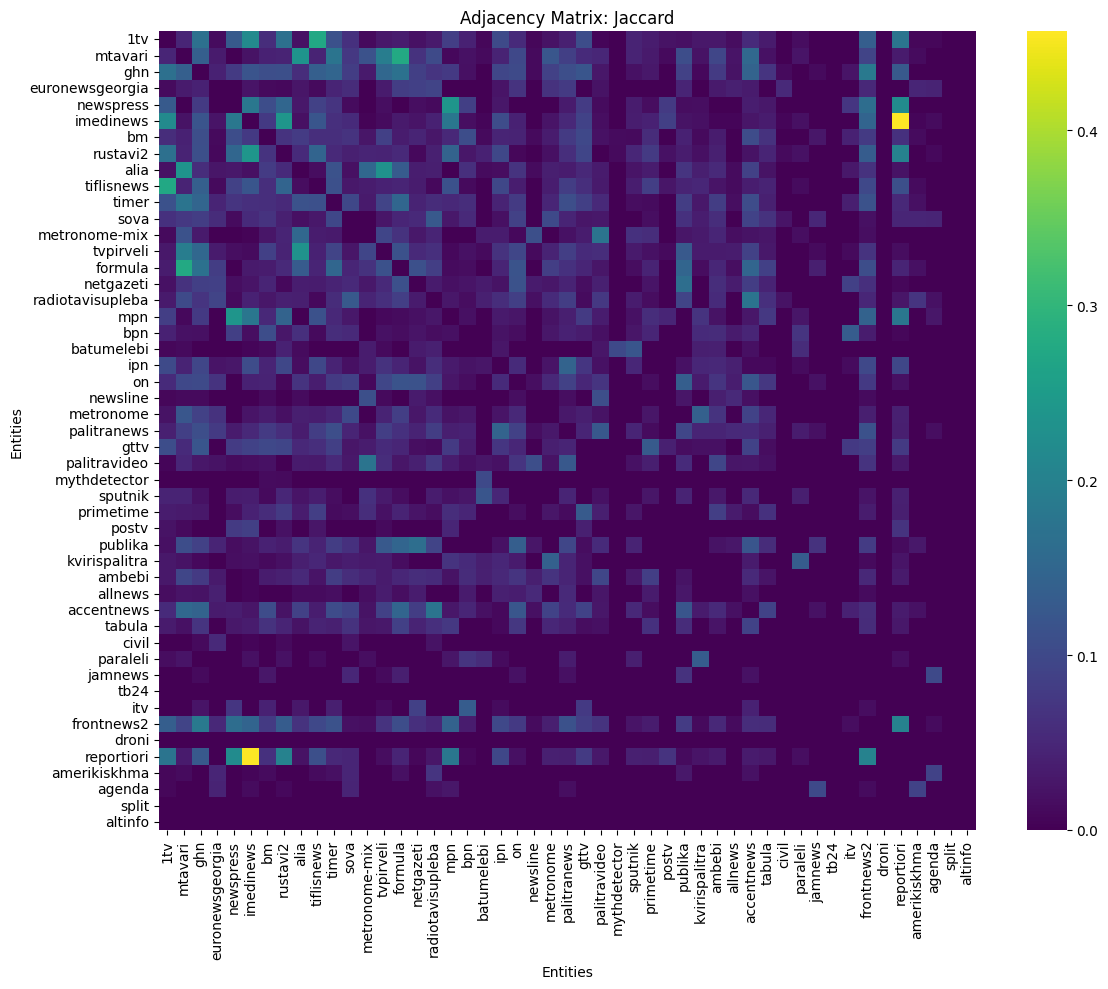

Successfully processed and visualized jaccard.

Processing method: dice...
Generated 'dice' matrix with shape: (49, 49)


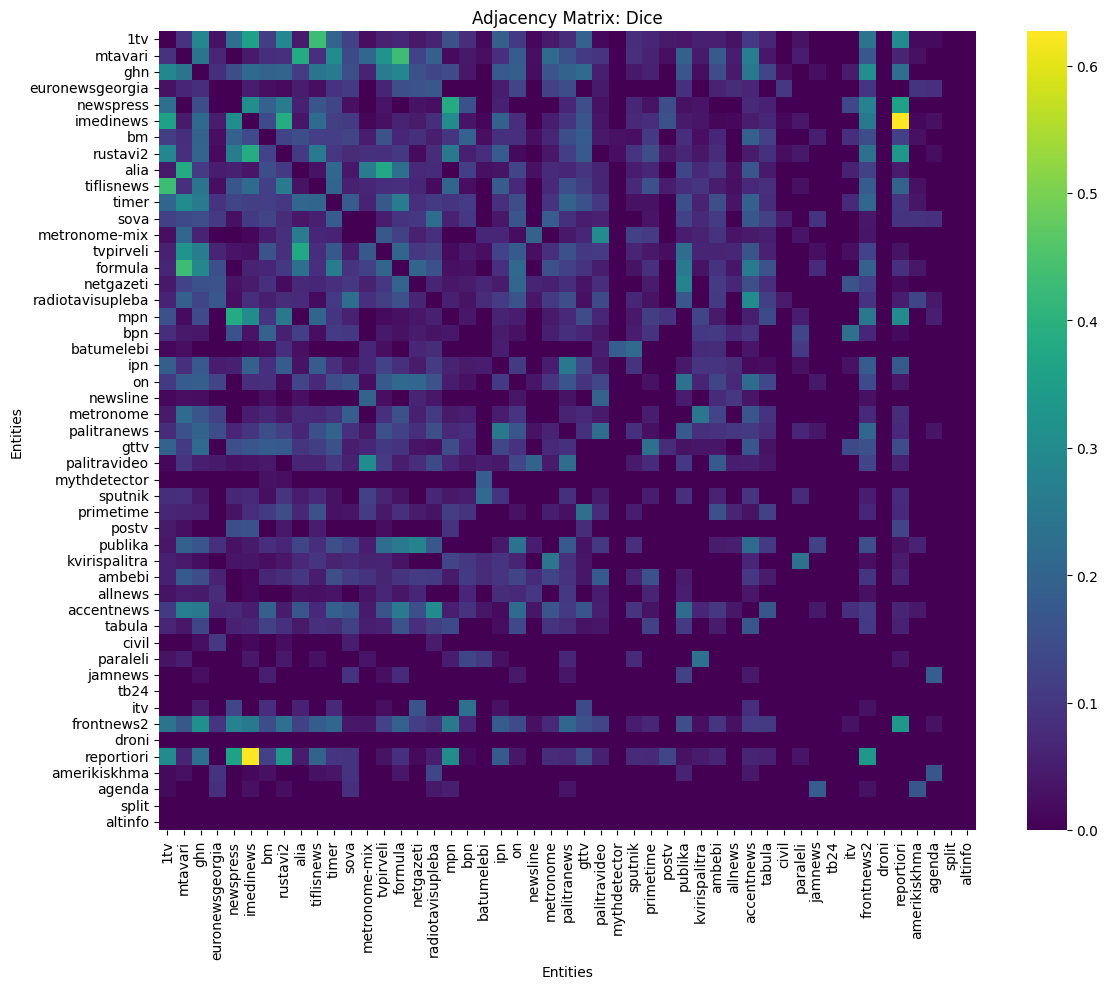

Successfully processed and visualized dice.

Processing method: cosine_nmf...
Generated 'cosine_nmf' matrix with shape: (49, 49)


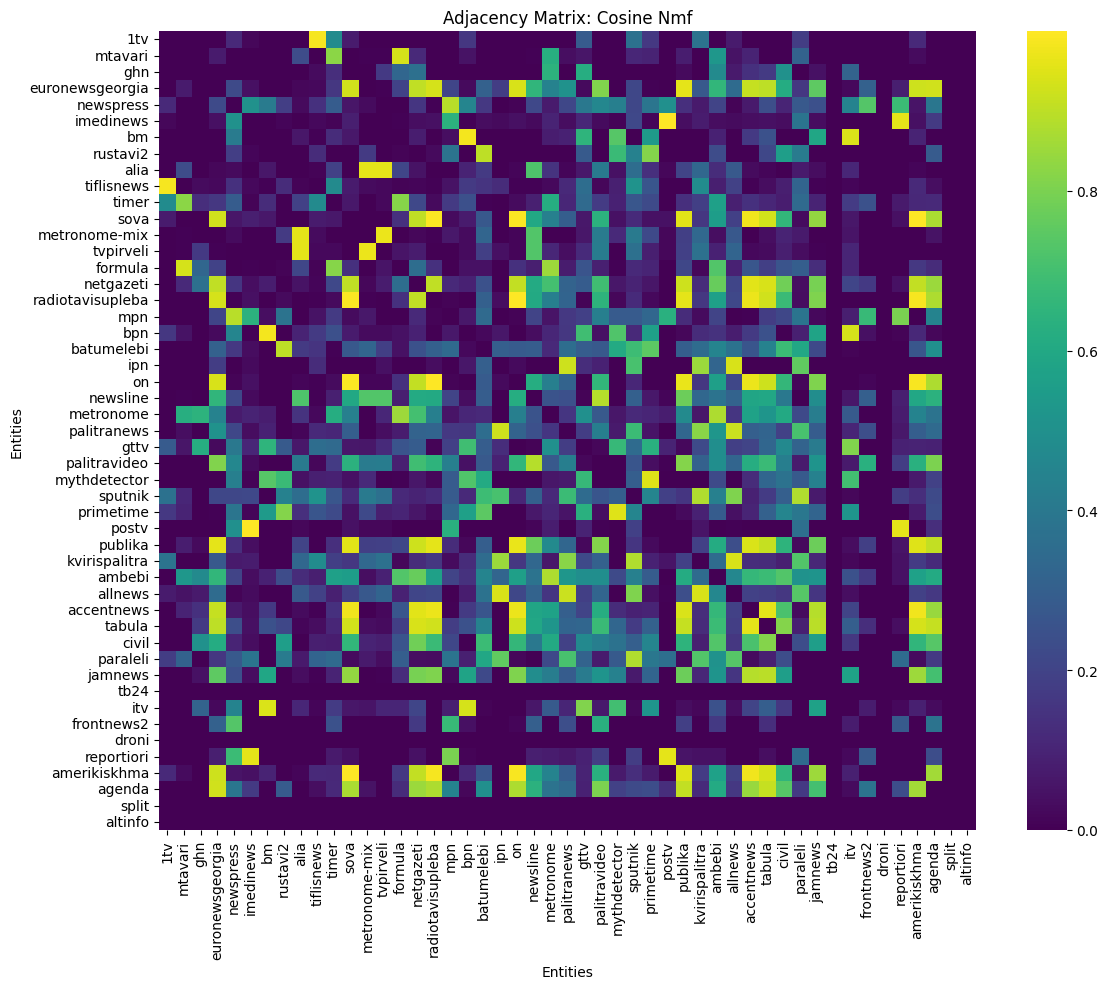

Successfully processed and visualized cosine_nmf.

Processing method: cosine_svd...
Generated 'cosine_svd' matrix with shape: (49, 49)


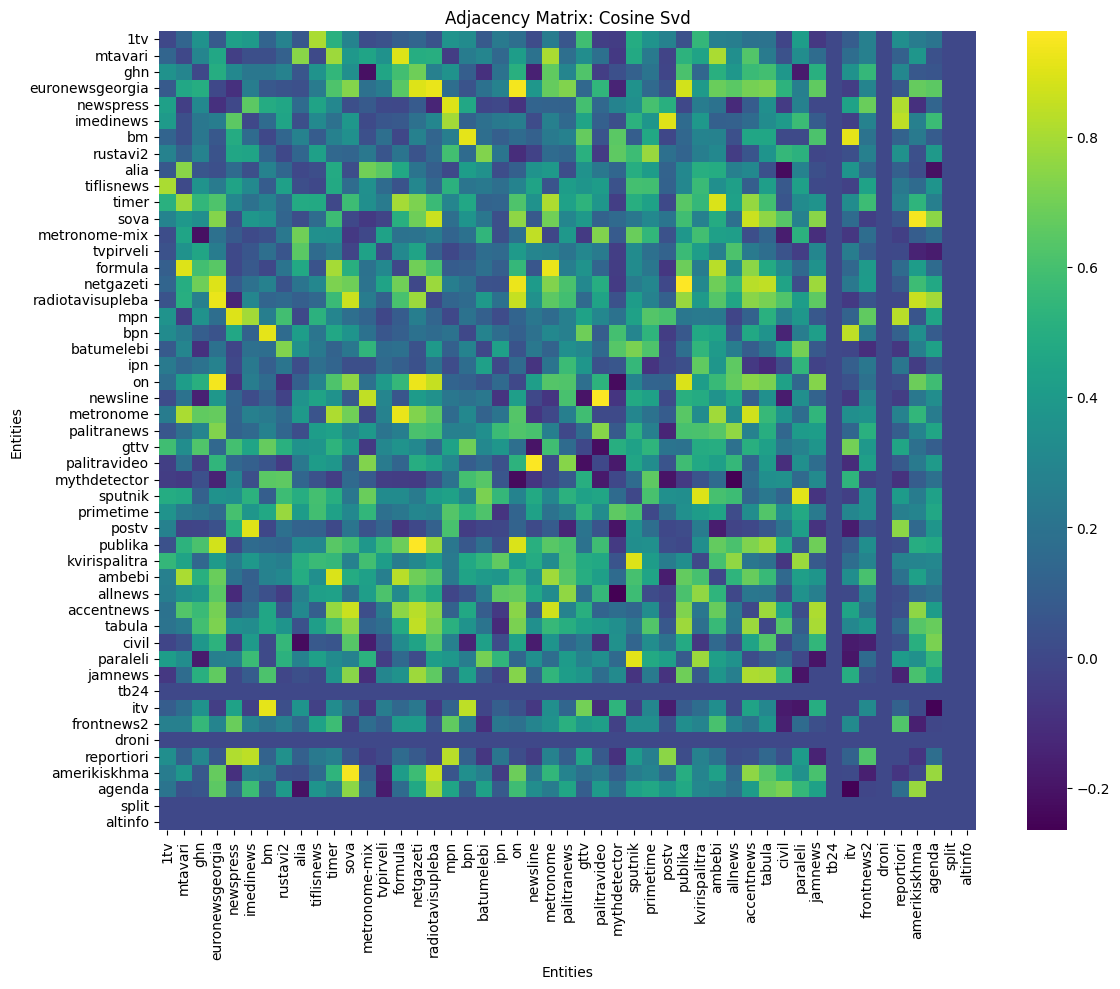

Successfully processed and visualized cosine_svd.

Processing method: correlation...
Generated 'correlation' matrix with shape: (49, 49)


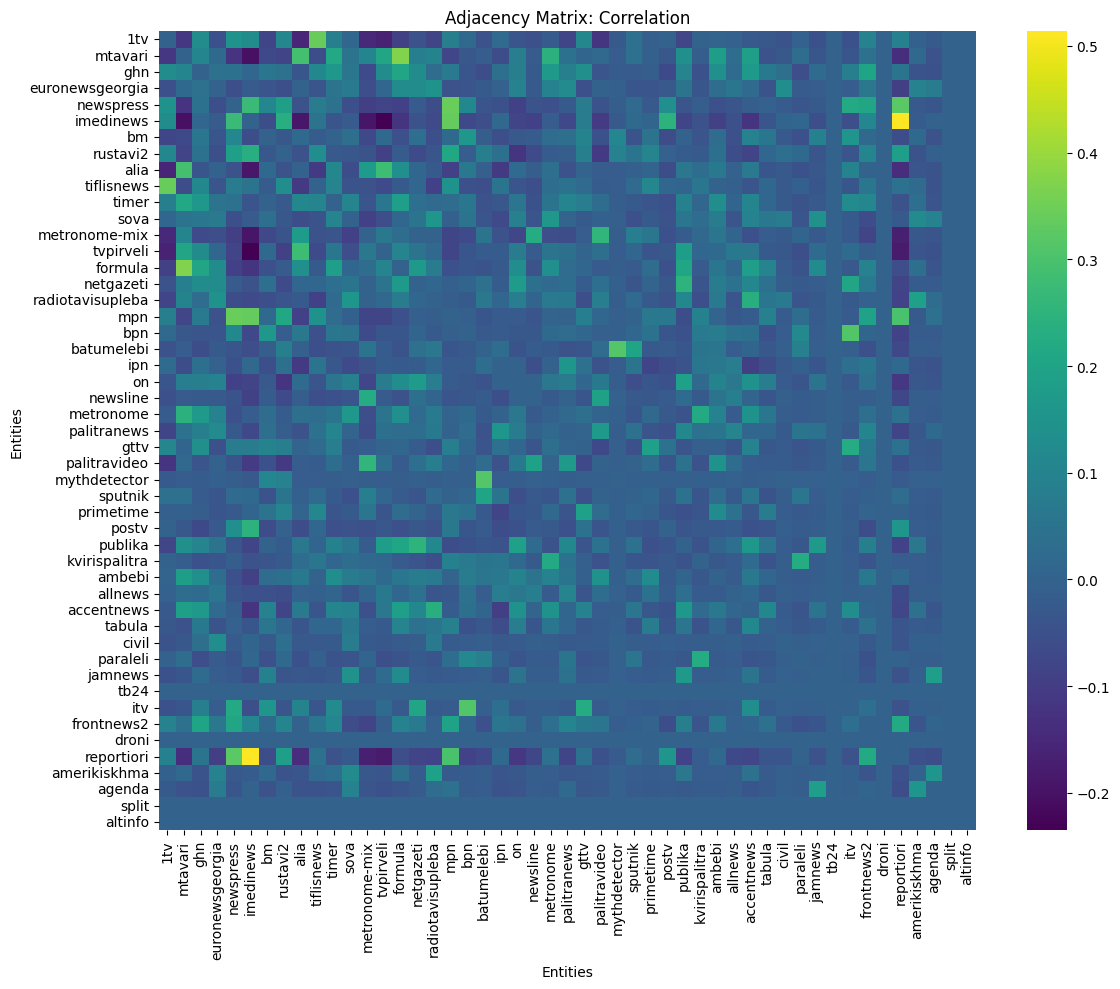

Successfully processed and visualized correlation.

Processing method: pmi...
Generated 'pmi' matrix with shape: (49, 49)


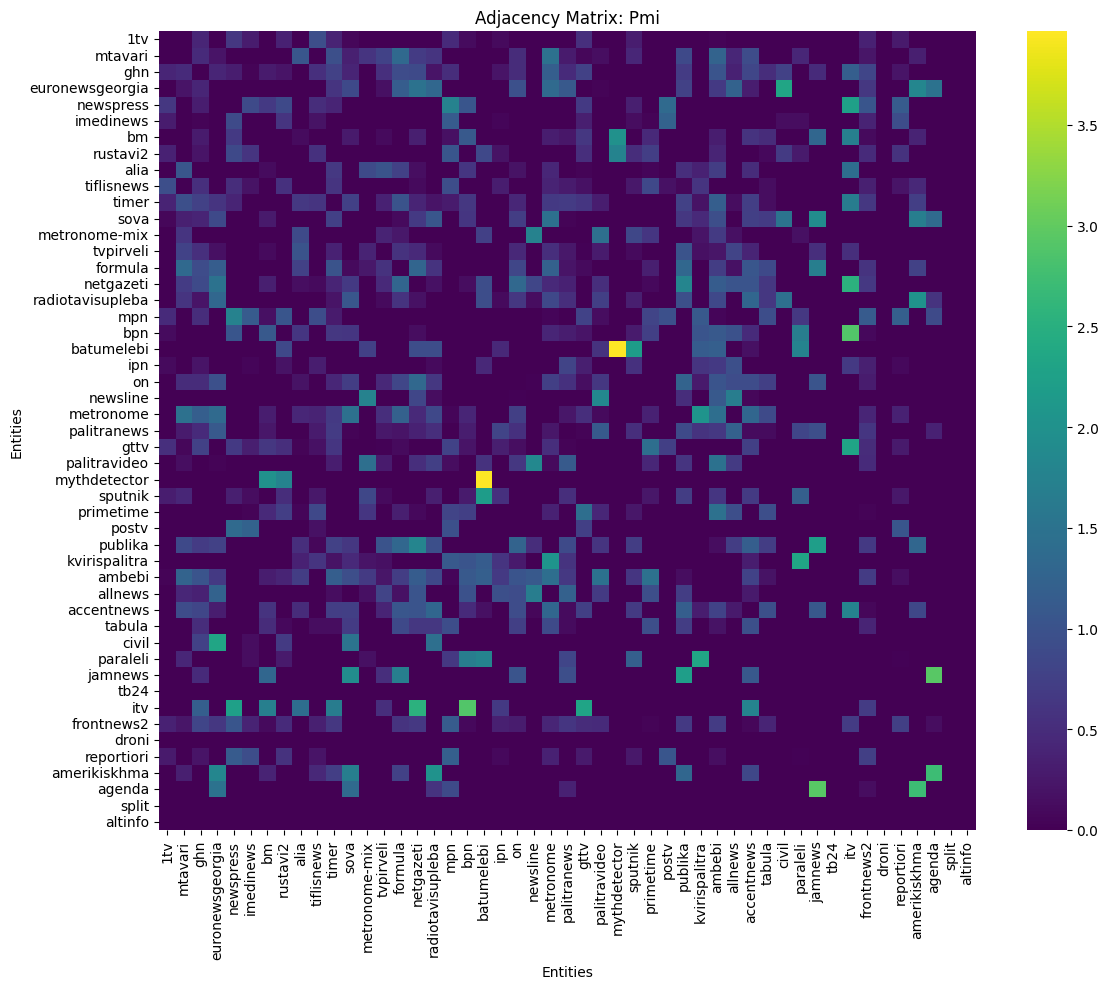

Successfully processed and visualized pmi.

Processing method: lift...
Generated 'lift' matrix with shape: (49, 49)


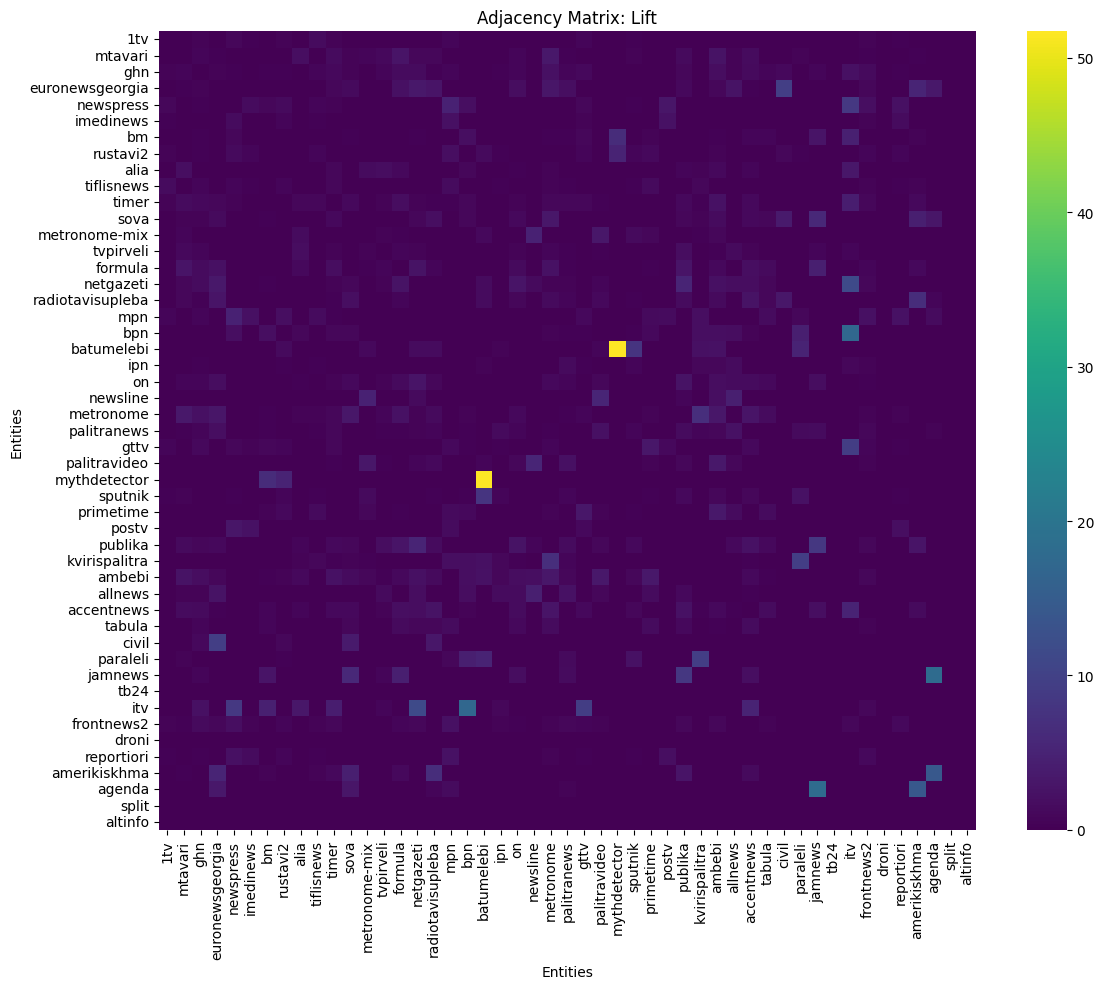

Successfully processed and visualized lift.

Processing method: tfidf...
Error processing method tfidf: '1tv'

Processing method: conditional...
Generated 'conditional' matrix with shape: (49, 49)


Traceback (most recent call last):
  File "/Users/alexamirejibi/miniconda3/envs/clusterizer/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: '1tv'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/jg/t7p4qrxx769bfwxs9l0nsqmh0000gn/T/ipykernel_11884/635108468.py", line 94, in main
    adj_matrix = analyzer.get_adjacency_matrix(method_name, **kwargs)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


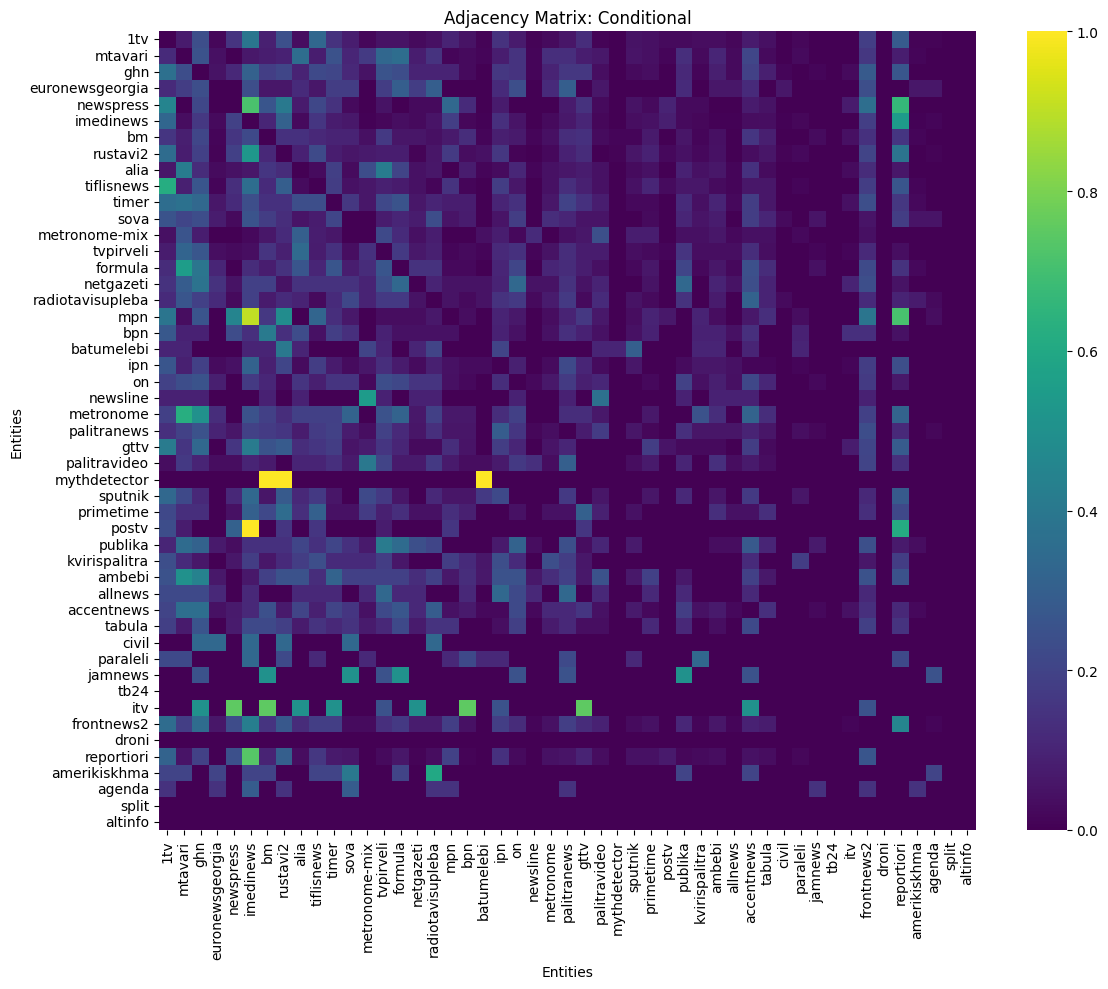

Successfully processed and visualized conditional.

Processing method: symmetric_conditional...
Generated 'symmetric_conditional' matrix with shape: (49, 49)


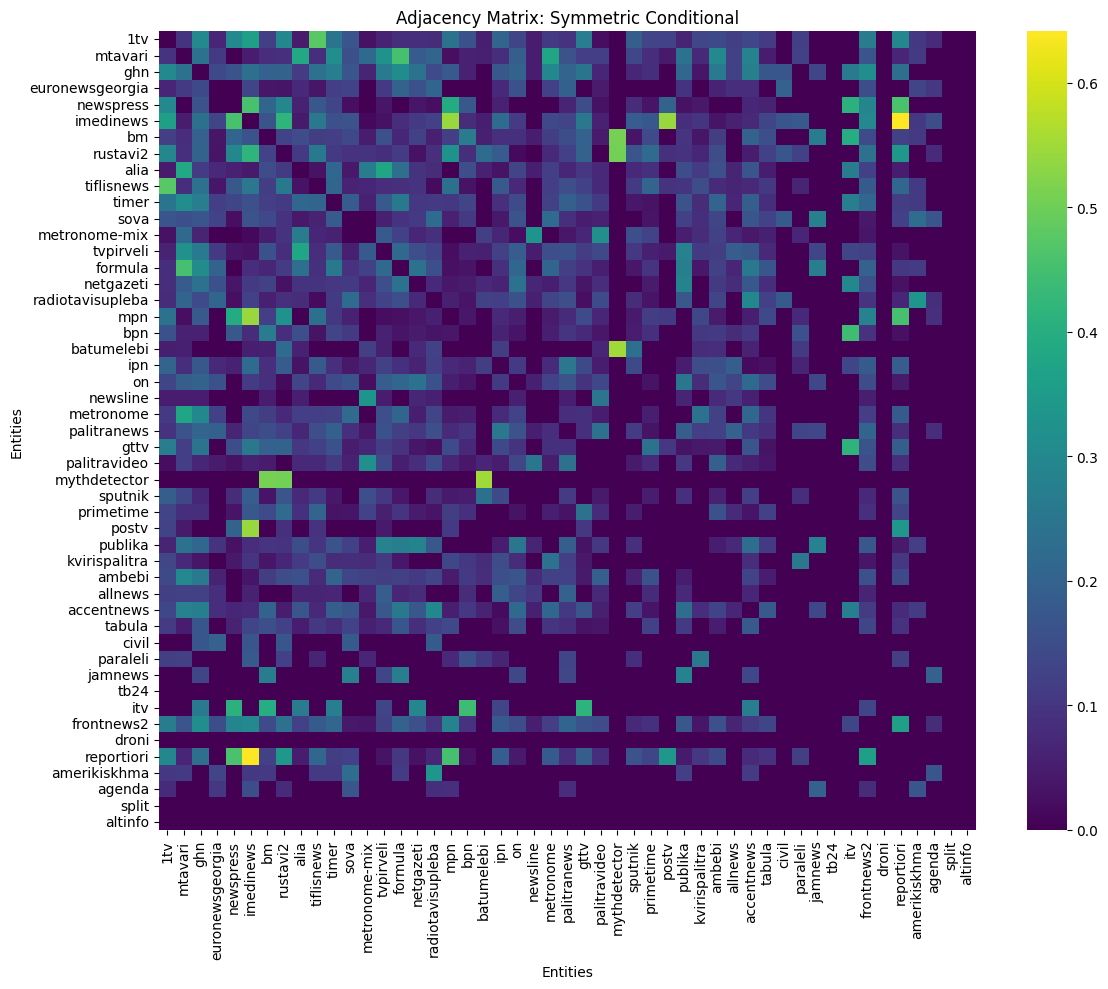

Successfully processed and visualized symmetric_conditional.


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from src.network_modeling import EntityAdjacencyMatrixMethods

def load_and_concatenate_data(data_dir, sample_size=60):
    """
    Loads all CSV files from the specified directory, prefixes columns,
    and concatenates them into a single DataFrame. Takes a random sample of files.
    """
    if not os.path.isdir(data_dir):
        print(f"Error: Data directory '{data_dir}' not found.")
        return None

    all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]
    
    if not all_files:
        print(f"No CSV files found in directory '{data_dir}'.")
        return None
        
    # Take random sample of files
    if len(all_files) > sample_size:
        all_files = np.random.choice(all_files, sample_size, replace=False)
        print(f"Taking random sample of {sample_size} files from {len(all_files)} total files")

    all_dataframes = []
    for file_path in all_files:
        try:
            df = pd.read_csv(file_path, index_col=0)
            if df.empty:
                print(f"Warning: File '{file_path}' is empty. Skipping.")
                continue
            
            file_basename = os.path.basename(file_path)
            prefix = os.path.splitext(file_basename)[0].replace("matrix_", "")
            df.columns = [f"{prefix}_{col}" for col in df.columns]
            all_dataframes.append(df)
        except Exception as e:
            print(f"Error reading or processing file {file_path}: {e}")
            continue

    if not all_dataframes:
        print("No dataframes were successfully loaded. Exiting.")
        return None

    concatenated_df = pd.concat(all_dataframes, axis=1)
    concatenated_df = concatenated_df.fillna(0)
    concatenated_df = concatenated_df.astype(int)
    
    if concatenated_df.empty:
        print("Concatenated DataFrame is empty after processing. Exiting.")
        return None
    if concatenated_df.shape[1] == 0:
        print("Concatenated DataFrame has no columns after processing. Exiting.")
        return None
        
    return concatenated_df

def main():
    data_dir = "daily_cluster_data/daily_cluster_matrices_min_6"
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    concatenated_df = load_and_concatenate_data(data_dir, sample_size=2)

    if concatenated_df is None:
        print("Failed to load data. Exiting.")
        return

    print(f"Successfully loaded and concatenated data. Shape: {concatenated_df.shape}")
    print(f"Entities (columns): {concatenated_df.columns.tolist()[:5]}... (Total: {len(concatenated_df.columns)})")

    analyzer = EntityAdjacencyMatrixMethods(concatenated_df)

    methods_to_run = [
        'cooccurrence', 'jaccard', 'dice',
        'cosine_nmf', 'cosine_svd',
        'correlation', 'pmi', 'lift', 'tfidf',
        'conditional', 'symmetric_conditional'
    ]
    
    method_kwargs = {
        'cosine_nmf': {'n_components': 10},
        'cosine_svd': {'n_components': 10}
    }

    for method_name in methods_to_run:
        print(f"\nProcessing method: {method_name}...")
        try:
            kwargs = method_kwargs.get(method_name, {})
            adj_matrix = analyzer.get_adjacency_matrix(method_name, **kwargs)

            if adj_matrix is None or adj_matrix.empty:
                print(f"Adjacency matrix for {method_name} is None or empty. Skipping heatmap.")
                continue
            if adj_matrix.shape[0] == 0 or adj_matrix.shape[1] == 0:
                print(f"Adjacency matrix for {method_name} has zero dimensions ({adj_matrix.shape}). Skipping heatmap.")
                continue
            
            print(f"Generated '{method_name}' matrix with shape: {adj_matrix.shape}")

            plt.figure(figsize=(12, 10))
            show_annotations = adj_matrix.shape[0] <= 30
            sns.heatmap(adj_matrix, annot=show_annotations, cmap="viridis", fmt=".2f")
            plt.title(f"Adjacency Matrix: {method_name.replace('_', ' ').title()}")
            plt.xlabel("Entities")
            plt.ylabel("Entities")
            plt.tight_layout()
            plt.show()
            
            print(f"Successfully processed and visualized {method_name}.")

        except Exception as e:
            print(f"Error processing method {method_name}: {e}")
            import traceback
            traceback.print_exc()

if __name__ == "__main__":
    main()


In [12]:
import pandas as pd
import numpy as np
import os

data_dir = "daily_cluster_data/daily_cluster_matrices_min_6"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]

all_dataframes = []
for file_path in all_files:
    df = pd.read_csv(file_path, index_col=0)
    file_basename = os.path.basename(file_path)
    prefix = os.path.splitext(file_basename)[0].replace("matrix_", "") 
    df.columns = [f"{prefix}_{col}" for col in df.columns]
    all_dataframes.append(df)

concatenated_df = pd.concat(all_dataframes, axis=1)
concatenated_df = concatenated_df.fillna(0)
concatenated_df = concatenated_df.astype(int)

co_occurrence_matrix = concatenated_df.dot(concatenated_df.T)
# print(concatenated_df.head())
co_occurrence_matrix.head()


,1tv,mtavari,ghn,euronewsgeorgia,newspress,imedinews,bm,rustavi2,alia,tiflisnews,...,jamnews,tb24,itv,frontnews2,droni,reportiori,amerikiskhma,agenda,split,altinfo
1tv,12297,1033,3062,297,1877,5716,1326,3598,800,2654,...,38,16,3,2337,2,3043,104,121,7,241
mtavari,1033,9504,2711,314,136,902,1433,978,2347,422,...,148,12,18,1285,40,299,118,30,11,134
ghn,3062,2711,10887,380,1320,2991,1807,2200,1605,1231,...,122,19,85,2328,32,1582,135,72,5,198
euronewsgeorgia,297,314,380,2022,71,371,336,343,241,105,...,64,4,2,229,2,118,86,19,1,56
newspress,1877,136,1320,71,7558,5444,1280,3087,615,792,...,16,5,207,2138,2,3748,5,131,3,83
